# level-flight-calculations

In [1]:
import os
import sys
projdir = os.path.abspath('../..')
if not projdir in sys.path:
    sys.path.insert(0,projdir)

We will use Erbach's scheme to determine the level flight velocity. I will add code to determine the best angle for level flight and avoid Erbach's need to deal with "terrifying yards of tabulated data" to find this flight setting!

## Erbach's Moment Calculations

Erbach set the wing and stab incidence, then conducted an angle of attack survey to generate the needed data. At each angle of attack, his code calculates the lift and drag forces for the wing and stab. He then calculates the resulting pitching moment using these forces. He plotted the pitching moment curve looking for the zero point, which is where the model would fly level.

Since we are doing these calculations numerically anyway, it is easy to set up a coordinate transformation system that calculates moments in a coordinate system centered on the center of gravity, and rotated so the body is located at the desired angle of attack. I packaged these transformations in a simple Python routine named **transform**. It takes the center of gravity coordinates and an angle of attack, together with a point of interest as parameters. It returns those coordinates in the CG-centered system.

The translation will move the model system from the nose to the center of gravity, then we will rotate the system  by a negative $\alpha$ which will be nose up. The code for this transformation is fairly simple:

In [2]:
def transform(xcg,ycg, alpha, xp, yp):
    rad = alpha * np.pi/180
    xt = xp - xcg
    yt = yp - ycg
    x = xt * np.cos(rad) + yt * np.sin(rad)
    y = -xt * np.sin(rad) + yt * np.cos(rad)
    return x,y


In [3]:
import mmtime

In [4]:
# model coordinates (referenced to lower body nose)
import numpy as np
import math
from mmtime.utils import show_curve, show_curve2

## Loading Airfoil Data

In [5]:
from mmtime.AirfoilMgr import AirfoilMgr

In [6]:
data_dir = '../../mmtime/data/airfoils'
am = AirfoilMgr(data_dir)
am.showAirfoils()

['mcbride-b7', 'arc0401', 'arc5', 'simplex0401', 'arc3', 'xfoil', 'simplex0301', 'arc0301', 'simple', 'simplex', 'turns2d', 'simplex0201', 'arc0201', 'simplex0601', 'flat0001', 'simplex0101', 'simplex0501']


In [7]:
am.selectAirfoil('simplex0401')

Selected: simplex0401


In [8]:
clw, cdw, cmw, cpw = am.loadData('re3k')

Loading simplex0401
	Loading CD_re3k.csv
	Loading CP_re3k.csv
	Loading CM_re3k.csv
	Loading CL_re3k.csv


In [9]:
am.selectAirfoil('simplex0201')
cls, cds, cms, cps = am.loadData('re3k')

Selected: simplex0201
Loading simplex0201
	Loading CD_re3k.csv
	Loading CP_re3k.csv
	Loading CM_re3k.csv
	Loading CL_re3k.csv


We now have the coefficient curve fit functions available to run the calculations. 

Before we continue, let's look at the coefficient curves:

In [10]:
import matplotlib.pyplot as plt

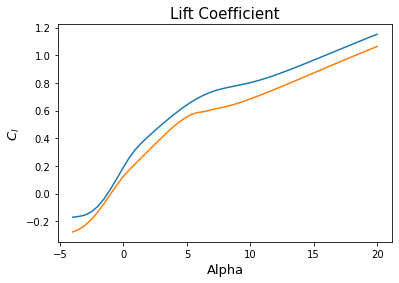

In [11]:
x = np.linspace(-4,20,50)
clx1  = clw(x)
clx2 = cls(x)
show_curve2(x,clx1,clx2,"wing","stab","Lift Coefficient","Alpha","$C_l$")

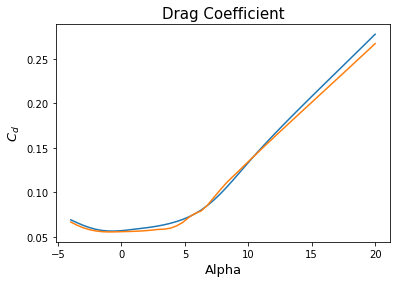

In [12]:
cdx1  = cdw(x)
cdx2 = cds(x)
show_curve2(x,cdx1,cdx2,"wing","stab","Drag Coefficient","Alpha","$C_d$")

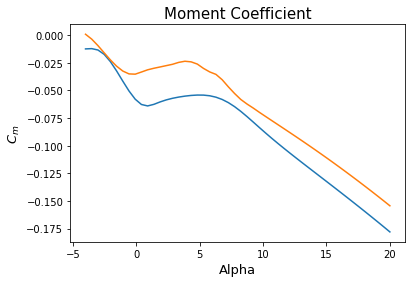

In [13]:
cmx1  = cmw(x)
cmx2 = cms(x)
show_curve2(x,cmx1,cmx2,"wing","stab","Moment Coefficient","Alpha","$C_m$")

## Loading Model Dimensions

All model data is stored in a data file for loading. Since this data is dimensional, we need to create a **pint** *UnitRegistry* here, and pass it to the data routine:

## Loading Model Moment Arms

We need to define the moment arms for the wing and stab. All model dimension data is loaded from a model file that sets up basic dimensions and calculates a few other dimensions we will need:

In [14]:
import pint
u = pint.UnitRegistry()

In [15]:
from mmtime.data.models.wart import data

In [16]:
wart = data.Wart(u)
mdata = wart.model_data()

In [17]:
xcg = mdata['cg'][0]
ycg = mdata['cg'][1]
xwac = 1.5 * u.inch
ywac = 7/8 * u.inch
xsac = (6+8.5-1) * u.inch
ysac = 0.125 * u.inch
wgt = mdata['flying_wgt']
sw = mdata['wing']['projected_area']
ss = mdata['stab']['projected_area']

Next, we need to calculate the air density from the standard atmosphere model.

In [18]:
from mmtime.StdAtm import Air
s = Air(u)
p = s.get_properties(864)
rho = p['rho']
print((rho.to('ounce/ft**3')).magnitude)

1.192951469114702


The wart is constructed with the wing set at zero incidence and the stab at -2 degrees. We will run the angle of attack survey from -4 to 10 degrees for our example. **numpy** makes generating lists of values a snap! **x** has our angle of attack survey points.

In [19]:
# calculate stab angle of attack
sa = x - 2

# load coefficient arrays
cl_w = clw(x)
cd_w = cdw(x)
cm_w = cmw(x)
cl_s = cls(sa)
cd_s = cds(sa)
cm_s = cms(sa)

Next, we calculate the velocity required to maintain level flight for each of these survey settings. The lift required is equal to the model weight so we calculate the lift generated by the wing and stab at each setting. This calculation is done in steps to avoid taking the square root of a negative number. If the lift goes negative, we will get a negative velocity which makes no sense. We will filter those values out.

The definition of the lift coefficient is given by:

\begin{equation}
C_l = \frac{2wg}{\rho V^2 S}
\end{equation}

The predicted flight speed calculation is thus given by:
    
\begin{equation}
V = \sqrt{\frac{2 w g}{\rho C_l S}}
\end{equation}

We will need to introduce the acceleration due to gravity to make the units work.

Since our lift curve pases through zero, there will be a problem trying to generate the velocity curve from this equation. We will need to ignore the negative lift part of the curve for our calculations.

In [20]:
K1 = (2 * wgt * u.gravity/rho).to_base_units()
K1

0.0338293961192986 <Unit('meter ** 4 / second ** 2')>

In [21]:
TL = (cl_w * sw + cl_s * ss)

In [22]:
# start velocity calculation for this configuration
VE2 = K1/TL

We need to filter this list by eliminating the negative (and zero lift) values.

In [23]:
jj = 0
for i in range(len(x)):
    jj = i
    if VE2[i].magnitude > 0: break
v = VE2[jj:]**0.5
x = x[jj:]

/Users/rblack/_dev/live-2022/.direnv/python-3.10.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


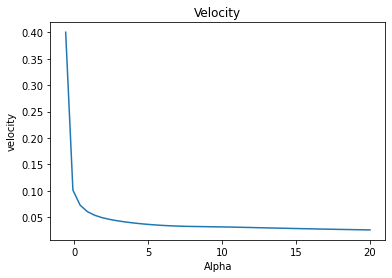

In [24]:
show_curve(x,v,"Velocity","Alpha","velocity")

In [25]:
wla, wda = transform(xcg, ycg, x, xwac, ywac)
sla, sda = transform(xcg, ycg, x, xsac, ysac)

In [26]:
sda

Magnitude,[0.0802082979528144 -0.0005040902665827286 -0.08121644164843085 -0.16192285795309083 -0.24261744137464236 -0.3232942949718804 -0.40394752309924786 -0.4845712318376716 -0.5651595294252768 -0.6457065266879383 -0.7262063374696474 -0.8066530790626547 -0.8870408726373639 -0.9673638436719396 -1.0476161223816014 -1.1277918441475725 -1.2078851499456498 -1.2878901867743657 -1.367801108082709 -1.4476120741973761 -1.5273172527495162 -1.606910819100948 -1.6863869567698067 -1.765739857855597 -1.8449637234636171 -1.9240527641287313 -2.0030012002384416 -2.0818032624552507 -2.1604531921382684 -2.238945241764037 -2.317273675346545 -2.3954327688563968 -2.4734168106391112 -2.551220101832512 -2.6288369567831844 -2.706261703461969 -2.783488683878458 -2.8605122544944646 -2.937326786636441 -3.013926666906799 -3.090306297594131 -3.1664600970822705 -3.24238250025818]
Units,inch


In [27]:
# calculate stab angle of attack
sa = x - 2

# recalculate coefficient arrays
cl_w = clw(x)
cd_w = cdw(x)
cm_w = cmw(x)
cl_s = cls(sa)
cd_s = cds(sa)
cm_s = cms(sa)

In [28]:
q = 0.5 * rho * v ** 2
lift_wing = q * cl_w * sw
lift_wing.to_base_units()

Magnitude,[0.28886380817992513 0.032838928553067095 0.023919590929498403 0.020655584238927868 0.01886013416003337 0.01775018552316042 0.01709156816792002 0.01664788144705344 0.016284349146941723 0.015974604646950136 0.015708764234238514 0.015471351643528005 0.01525181993964836 0.015053208296004107 0.014884214318771878 0.014751466230034633 0.014646006972395207 0.014600459700660345 0.014609348490293474 0.014591607928622104 0.01455935397148593 0.014550347538624643 0.014541697167716663 0.014526279848689528 0.014503661823977426 0.014479669217034918 0.014456649561695508 0.014434179031438302 0.014412292162178523 0.014390939824343394 0.014370125583591768 0.014349826211286764 0.014330088376445787 0.014310904486650611 0.014292243534062934 0.01427413741946022 0.01425658838675909 0.014239552302147837 0.014223002726703779 0.01420690239140255 0.014191151589163618 0.014175665190059843 0.014160355288021823]
Units,kilogram meter/second2


In [29]:
q = rho * v**2/2
lift_wing = q * cl_w * sw
drag_wing = q * cd_w * sw
moment_wing = q * cm_w * sw * 2 * u.inch

lift_stab = q * cl_s * ss
drag_stab = q * cd_s * ss
moment_stab = q * cm_s * ss * 1.5 * u.inch

wing_drag_moment = wda * drag_wing
wing_lift_moment = wla * lift_wing
stab_lift_moment = sla * lift_stab
stab_drag_moment = sda * drag_stab
stab_drag_moment.to_base_units()

Magnitude,[0.00016719983616400393 -6.59660844751206e-08 -5.41343229250391e-06 -7.444940402714756e-06 -8.808695361426735e-06 -9.921749717078961e-06 -1.0893047114533151e-05 -1.1736566080819207e-05 -1.2475893845884287e-05 -1.316641004108273e-05 -1.3840540264186522e-05 -1.455103699849026e-05 -1.5145539730732594e-05 -1.5901343613099416e-05 -1.7144009051679247e-05 -1.888294973433651e-05 -2.1360033080650715e-05 -2.3792657823922747e-05 -2.5880606178258965e-05 -2.9068836365449353e-05 -3.329665758412661e-05 -3.7642566661326806e-05 -4.202375394501972e-05 -4.605273927137916e-05 -4.989352553805482e-05 -5.391174293377063e-05 -5.786601692104377e-05 -6.181013664266576e-05 -6.573276757588018e-05 -6.964246059561359e-05 -7.35428131161575e-05 -7.743872378994628e-05 -8.133410479839542e-05 -8.523398367583533e-05 -8.91422458726834e-05 -9.306129264117786e-05 -9.699406710906094e-05 -0.0001009434372258585 -0.00010491156566062657 -0.00010890154229494211 -0.00011291692113731282 -0.00011696058121143185 -0.00012103613022159822]
Units,kilogram meter2/second2


In [30]:
total_moment = - wing_lift_moment \
    + wing_drag_moment \
    - stab_lift_moment \
    - stab_drag_moment \
    + moment_wing + moment_stab
total_moment.to_base_units()

Magnitude,[0.07787789167877729 0.004745507637731428 0.002201734552573635 0.0012744812434293336 0.0007670640332447002 0.0004557297741951084 0.0002740914899138788 0.00015248206402342424 5.16530974127099e-05 -3.502694991069629e-05 -0.00010980174848724986 -0.000176985908294777 -0.00023949183520907328 -0.0002965000455766364 -0.0003453802646952042 -0.00038394530216683676 -0.0004146802557356716 -0.0004276590939563015 -0.0004244995528434933 -0.0004290570965517008 -0.00043742729155674316 -0.0004384049057423197 -0.0004387717054003565 -0.000440785544859526 -0.00044465008316523766 -0.0004486225663990328 -0.00045212923106552143 -0.0004553156969198572 -0.00045820073589379607 -0.0004608138777159603 -0.0004631663025231083 -0.0004652728567779545 -0.0004671248227094729 -0.00046872673628180135 -0.0004700884973169861 -0.0004712021424642945 -0.00047206844749963774 -0.0004726972556266547 -0.00047309600151880385 -0.00047327355542859333 -0.0004732547793813699 -0.0004730605556406376 -0.0004727116130864305]
Units,kilogram meter2/second2


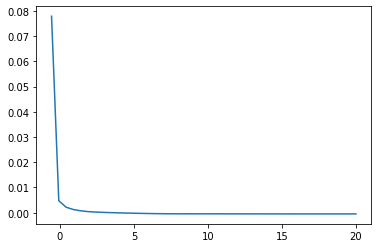

In [31]:
plt.plot(x, total_moment.to_base_units().magnitude)
plt.show()

In [32]:
from mmtime.utils import fit_curve
m_a = fit_curve(x, total_moment)
zero_angle  = m_a.solve(y=0)
zero_angle

/Users/rblack/_dev/live-2022/.direnv/python-3.10.5/lib/python3.10/site-packages/scipy/interpolate/_cubic.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x, y = map(np.asarray, (x, y))


array([3.63107448])

In [34]:
alpha = zero_angle
alpha * u.degrees

Magnitude,[3.631074482280199]
Units,degree


In [35]:
VE = 2 * wgt /(rho/u.gravity*(clw(alpha) * sw + cls(alpha-2) * ss))
v = np.sqrt(VE)
v.to('mph')

Magnitude,[3.589166603945602]
Units,mile_per_hour


Now, let's calculate the Reynolds Number for this velocity:

In [36]:
mean_chord = 1.85 * u.inch
mu = Air(u).get_properties(864)['mu']
density = Air(u).get_properties(864)['rho']
RE = density * v * mean_chord / mu
RE.to_base_units()

Magnitude,[5055.667485541922]
Units,dimensionless


These calculations are for our 2D model. McLean included some 3D effects by adding in induced drag.

## Induced Drag

When air flows over a lifting surface several interesting things happen. One is the formation of two vortices that appear behind the wing tips. Although it is common to talk about the formation of these vortices as a result of the pressure difference between the upper and lower surfaces, their formation is more complicated than that. (For a good discussion of this, see Doug McLean’s 2005 article on wing-tip design {cite}`mclean2005`. 

A side effect of those vortices is a downward deflection of the airstream behind the wing that influences the effective angle of attack of the stabilizer. This downward flow is called *Downwash*. 

In initial designs, the downwash angle can be estimated using this equation:

\begin{equation}
\epsilon = \frac{2C_{lw}}{\pi{AR}_w}
\end{equation}

The induced drag due to the wing is given by:
\begin{equation}
C_{diw} = \frac{1}{\pi {AR}_w}
\end{equation}

And the induced drag due to the stab is given by:

\begin{equation}
C_{dis} = \frac{C_{ls}^2}{\pi {AR}_s} + 2 C_{ls}C_{diw}
\end{equation}
Where:

\begin{equation}
{AR}_{wing} = \frac{b_w^2}{S_f}
\end{equation}

\begin{equation}
{AR}_{stab} = \frac{b_s^2}{S_s}
\end{equation}

Here:
- $b_w$ is the wing span
- $b_s$ is the stab span
- $S_w$ is the wing projected area
- $S_s$ is the stab projected span

In [37]:
b_w = mdata['wing']['projected_span']
a_w = mdata['wing']['projected_area']
b_s = mdata['stab']['projected_span']
a_s = mdata['stab']['projected_area']

aspect_ratio_wing = b_w**2/a_w
aspect_ratio_stab = b_s**2/a_s
print(aspect_ratio_wing, aspect_ratio_stab)

7.8871660432942985 dimensionless 7.959312965493482 dimensionless


The downwash angle seen by the stabilizer is calculated next:

In [38]:
eps = 2.0*cl_w/(aspect_ratio_wing * math.pi)
eps*180/math.pi

Magnitude,[0.4708216585459101 0.8304696052429581 1.1695106173031853 1.4553342819774586 1.6834954376479758 1.8808780019931224 2.068268774699325 2.2506680704842124 2.4278712780722485 2.5986703392281028 2.7613600694682403 2.913842734729647 3.0536541866582545 3.178231915761888 3.285499049651132 3.3745782309849894 3.44654120200397 3.504349460447585 3.5521763826485406 3.594783557446779 3.6368156160574294 3.6820547911313795 3.7328531710943715 3.790043212353827 3.8533304795156536 3.9218827247773915 3.9947545005468705 4.071063631996272 4.150063147940985 4.231126023357798 4.313739495070567 4.397494824071387 4.482083903429996 4.567214430142499 4.6526677322316985 4.738275886272328 4.823869350978623 4.909337834587565 4.99451780172789 5.079251393770221 5.163379364159408 5.246741480473677 5.329177510291253]
Units,dimensionless


Those angle are significant! Our data will be suspect as the curve fit routines extrapolate to get stab values!

In [39]:
import math
C_lr = cls(alpha-2)
C_dif = 1.0/(math.pi * aspect_ratio_wing)
C_dir = C_lr ** 2/(math.pi* aspect_ratio_stab) + 2.0*C_lr*C_dif

The total induce drag is given by:

\begin{equation}
C_{di} = \frac{C_{dif} + \frac{S_r C_{dir}}{S_f}}{1 + \frac{S_r}{S_f}}
\end{equation}

In [40]:
C_di = (C_dif + C_dir*(a_s)/a_w)/ \
            (1.0 + a_s/a_w)
print(C_di)

[0.03550986951278996] dimensionless


The induced drag coefficients are added to the section coefficient data for both the wing and stab. The flight velocity needs to be recalculated to account for these changes.

We now can calculate the total drag from the wing and stab:

\begin{equation}
D = \frac{1}{2}\rho u^2 ((C_{dw} + C_{diw})*S_w + (C_{ds} + C_{dis})*S_s)
\end{equation}


In [41]:

D = 0.5 * rho * v**2 * \
    ((clw(alpha) + C_dif)*a_w + (cls(alpha-2) + C_dir)*a_s)
D.to_base_units()

Magnitude,[0.02176750710923581]
Units,kilogram meter/second2


## Including Downwash Effects

We will repeat the moment survey adding in induced drag effects. Only the drag calculations will change.

In [42]:
drag_wing = q * (cd_w + C_dif)* sw
drag_stab = q * (cd_s + C_dir) *ss

In [43]:
wing_drag_moment = wda * drag_wing
stab_drag_moment = sda * drag_stab
stab_drag_moment

Magnitude,[0.009497142816798861 -3.7776210894044983e-06 -0.0003115051310581758 -0.0004292168721333614 -0.0005077741489438436 -0.0005713142676534107 -0.0006265588110073705 -0.0006743495187192189 -0.0007156786598797161 -0.0007534438589404028 -0.0007895743972703252 -0.0008265359740475731 -0.0008586723425729976 -0.0008973917825963084 -0.0009560414392426693 -0.001035400149834148 -0.001144940390282463 -0.0012545100054445315 -0.001352089424992176 -0.00149244819445895 -0.00167301325655762 -0.0018580695655187381 -0.0020435552929400844 -0.002213912111832566 -0.002375587814910994 -0.0025432215819926403 -0.0027074914043712446 -0.002870617230368769 -0.003032256211701324 -0.0031928333411833125 -0.003352567033645174 -0.0035117134348771582 -0.0036704796492595068 -0.0038291114435196013 -0.0039877992912075435 -0.004146670399495484 -0.004305870966287587 -0.004465535207517089 -0.004625774198310909 -0.0047867332154853115 -0.004948572455473201 -0.0051114248899130224 -0.00527545091911101]
Units,inch kilogram meter/second2


In [51]:
total_moment2 = - wing_lift_moment \
    + wing_drag_moment \
    - stab_lift_moment \
    - stab_drag_moment \
    + moment_wing + moment_stab
total_moment2.to_base_units()

Magnitude,[0.07987039209104344 0.00488283335888568 0.002277365634703586 0.0013301547629971451 0.0008135232712151106 0.000496981551286228 0.0003120634328800248 0.00018812397136486054 8.546877235488234e-05 -2.6653352363050395e-06 -7.858847281149724e-05 -0.0001466744316722264 -0.0002098719327298491 -0.00026736438226625204 -0.0003165124850801461 -0.0003551275567632755 -0.00038573216266932854 -0.00039836363270355957 -0.00039468135741292616 -0.000398742416783377 -0.000406657876284604 -0.00040717446489672875 -0.0004071411333237764 -0.0004088377314583267 -0.0004124654996100395 -0.00041626024152396256 -0.00041963316048473605 -0.0004227217264441976 -0.0004255369800053733 -0.00042810222860028375 -0.00043042354993537077 -0.0004325118482743456 -0.0004343553072856502 -0.00043595580725146383 -0.00043732135325758725 -0.00043844243361326393 -0.00043931843731715266 -0.00043995842017158134 -0.0004403687023108776 -0.00044055718174449673 -0.00044054795434226966 -0.0004403611614904342 -0.00044001685620971684]
Units,kilogram meter2/second2


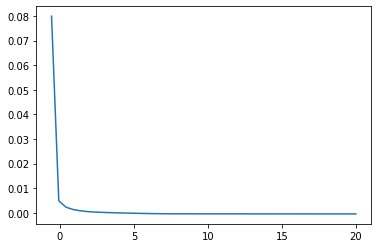

In [52]:
plt.plot(x, total_moment2.to_base_units().magnitude)
plt.show()

In [53]:
m_a2 = fit_curve(x, total_moment2)
zero_angle  = m_a2.solve(y=0)
alpha2 = zero_angle
alpha2

/Users/rblack/_dev/live-2022/.direnv/python-3.10.5/lib/python3.10/site-packages/scipy/interpolate/_cubic.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x, y = map(np.asarray, (x, y))


array([3.8208469])

Now we calculate the new level velocity:

In [54]:
VE_2 = 2 * wgt /(rho/u.gravity*(clw(alpha2) * sw + cls(alpha2-2) * ss))
v = np.sqrt(VE_2)
v.to('mph')

Magnitude,[3.530971196188258]
Units,mile_per_hour


In [55]:
total_drag = drag_wing + drag_stab
total_drag.to_base_units()

Magnitude,[0.3929500888716565 0.025257729566370894 0.013088473540318338 0.009126756727609823 0.0072481552331785755 0.006146728638353609 0.0054222720065607456 0.004895457763050244 0.004485886235036091 0.004164393915126265 0.003913349871453239 0.0037209917802242557 0.0035712139495546174 0.0034732478392937795 0.0034364574474519414 0.0034557174360533302 0.0035304523733325627 0.003634272340446225 0.0037529850092498478 0.0039045140604408316 0.004077216351820705 0.004246699950679164 0.0044019335805369555 0.00453107036026149 0.004639032596874928 0.004736801760642742 0.004821733473294975 0.004896783522627622 0.004963432639501056 0.005023262977186561 0.005077505604033039 0.005127167188872987 0.005173058392346326 0.0052158964548361724 0.005256256371758824 0.005294599020939445 0.0053312892053570884 0.0053666473181803375 0.005401001335835193 0.005434661004865281 0.005467902391388349 0.005500976670493731 0.005534124997754408]
Units,kilogram meter/second2


In [56]:
tg = total_drag.to_base_units()
tg

Magnitude,[0.3929500888716565 0.025257729566370894 0.013088473540318338 0.009126756727609823 0.0072481552331785755 0.006146728638353609 0.0054222720065607456 0.004895457763050244 0.004485886235036091 0.004164393915126265 0.003913349871453239 0.0037209917802242557 0.0035712139495546174 0.0034732478392937795 0.0034364574474519414 0.0034557174360533302 0.0035304523733325627 0.003634272340446225 0.0037529850092498478 0.0039045140604408316 0.004077216351820705 0.004246699950679164 0.0044019335805369555 0.00453107036026149 0.004639032596874928 0.004736801760642742 0.004821733473294975 0.004896783522627622 0.004963432639501056 0.005023262977186561 0.005077505604033039 0.005127167188872987 0.005173058392346326 0.0052158964548361724 0.005256256371758824 0.005294599020939445 0.0053312892053570884 0.0053666473181803375 0.005401001335835193 0.005434661004865281 0.005467902391388349 0.005500976670493731 0.005534124997754408]
Units,kilogram meter/second2


/Users/rblack/_dev/live-2022/.direnv/python-3.10.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


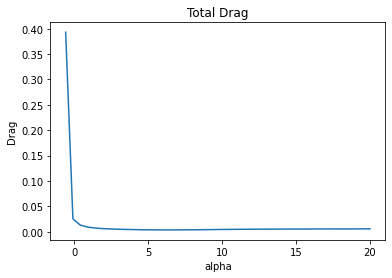

In [57]:
show_curve(x,tg,"Total Drag","alpha","Drag")

In [58]:
tgf = fit_curve(x,tg)
level_drag = tgf(alpha2)
level_drag * u.kilogram * u.meter/u.second**2

/Users/rblack/_dev/live-2022/.direnv/python-3.10.5/lib/python3.10/site-packages/scipy/interpolate/_cubic.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x, y = map(np.asarray, (x, y))


Magnitude,[0.004173732398264102]
Units,kilogram meter/second2


We will need this number when analyzing the propeller for the model.